In [73]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter

In [3]:
df = pd.read_csv('data/all-data.csv', encoding='latin_1', header=None)
df.head(10)

,0,1
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,positive,"For the last quarter of 2010 , Componenta 's n..."
7,positive,"In the third quarter of 2010 , net sales incre..."
8,positive,Operating profit rose to EUR 13.1 mn from EUR ...
9,positive,"Operating profit totalled EUR 21.1 mn , up fro..."


In [4]:
df.columns = ['sentiment', 'news_title']

In [209]:
# Split the data into features (X) and labels (y)
X = df["news_title"]
y = df["sentiment"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [210]:
def preprocess_string(s):
    s = re.sub(r"[^\w\s]", '', s)
    s = re.sub(r"\s+", '', s)
    s = re.sub(r"\d", '', s)
    return s

def tokenize(x_train, y_train, x_test, y_test):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:500]
    onehot_dict = {w: i + 1 for i, w in enumerate(corpus_)}
    
    final_list_train, final_list_test = [], []
    for sent in x_train:
        final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                 if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_test:
        final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                if preprocess_string(word) in onehot_dict.keys()])

    # Encoding labels with 3 classes
    label_mapping = {'neutral': 0, 'negative': 1, 'positive': 2}
    encoded_train = [label_mapping[label] for label in y_train]
    encoded_test = [label_mapping[label] for label in y_test]

    return np.array(final_list_train, dtype=object), np.array(encoded_train), np.array(final_list_test, dtype=object), np.array(encoded_test), onehot_dict

In [211]:
X_train, y_train, X_test, y_test, vocab = tokenize(X_train, y_train, X_test, y_test)
X_train[:10], y_train[:10]

(array([list([82, 185, 239, 23]), list([358, 141, 69, 341, 267, 87, 29]),
        list([2, 149, 8, 6, 25, 132, 359, 14, 384]),
        list([475, 289, 17, 310, 289]), list([33, 101, 14]),
        list([159, 311]),
        list([420, 17, 450, 33, 476, 163, 450, 23, 450, 23]), list([142]),
        list([169, 29, 1]), list([147, 40, 18, 169, 25, 19, 248, 28, 1])],
       dtype=object),
 array([0, 0, 2, 0, 0, 2, 2, 2, 2, 0]))

In [212]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 500


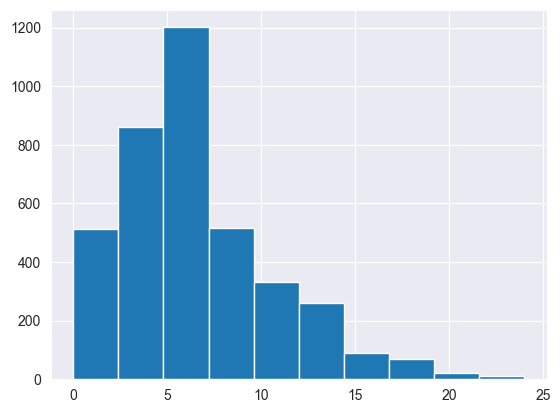

count    3876.000000
mean        6.530702
std         4.048778
min         0.000000
25%         4.000000
50%         6.000000
75%         9.000000
max        24.000000
dtype: float64

In [213]:
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).hist()
plt.show()
pd.Series(rev_len).describe()

In [214]:
def padding(data):
    max_length = max(len(item) for item in data)
    # Pad each list to the maximum length
    padded_data = np.array([item + [0] * (max_length - len(item)) for item in data])
    
    return padded_data

In [215]:
X_train_pad = padding(X_train)
X_test_pad = padding(X_test)
X_train_pad

array([[ 82, 185, 239, ...,   0,   0,   0],
       [358, 141,  69, ...,   0,   0,   0],
       [  2, 149,   8, ...,   0,   0,   0],
       ...,
       [ 42, 143, 158, ...,   0,   0,   0],
       [475,  72,  66, ...,   0,   0,   0],
       [391, 128,   5, ...,   0,   0,   0]])

In [216]:
train_data = TensorDataset(torch.from_numpy(X_train_pad), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test_pad), torch.from_numpy(y_test))

train_loader = DataLoader(train_data, shuffle=True, batch_size=32, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=32, drop_last=True)
len(train_loader), len(test_loader)

(121, 30)

In [253]:
# Build the model
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.hidden_dim = hidden_dim
    
    def forward(self, x, hidden):
        embs = self.embedding(x)
        # print(embs.shape)
        out, hidden = self.lstm(embs, hidden)
        out = self.dropout(out)
        out = self.fc(out)
        out = out[:, -1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        h0 = torch.zeros((1, batch_size, self.hidden_dim))
        c0 = torch.zeros((1, batch_size, self.hidden_dim))
        hidden = (h0,c0)
        return hidden

In [254]:
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 3
hidden_dim = 128
dropout = 0.2

model_0 = LSTM(vocab_size, embedding_dim, hidden_dim, output_dim, dropout)
model_0

LSTM(
  (embedding): Embedding(501, 64, padding_idx=0)
  (lstm): LSTM(64, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)

In [255]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr = 0.001)

In [256]:
NUM_EPOCHS = 10
results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

for epoch in range(NUM_EPOCHS):
    model_0.train()
    train_loss, train_acc = 0, 0
    h = model_0.init_hidden(32)
    for batch, (X, y) in enumerate(train_loader):
        h = tuple([each.data for each in h])
        y_pred, h = model_0(X, h)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += (y_pred.argmax(dim=1) == y).sum().item() / len(y)
        optimizer.zero_grad()
        loss.backward()
        # nn.utils.clip_grad_norm(model_0.parameters(), max_norm=1)
        optimizer.step()
    
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    
    test_h = model_0.init_hidden(32)
    test_loss, test_acc = 0, 0
    model_0.eval()
    for batch, (X, y) in enumerate(test_loader):
        test_h = tuple([each.data for each in test_h])
        test_pred, test_h = model_0(X, test_h)
        test_loss += loss_fn(test_pred, y).item()
        test_acc += (test_pred.argmax(dim=1) == y).sum().item() / len(y)
    
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    
    print(f'Epoch: {epoch+1:2} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Epoch:  1 | Train Loss: 0.920 | Train Acc: 60.38% | Test Loss: 0.834 | Test Acc: 64.69%
Epoch:  2 | Train Loss: 0.852 | Train Acc: 64.00% | Test Loss: 0.816 | Test Acc: 65.42%
Epoch:  3 | Train Loss: 0.813 | Train Acc: 65.32% | Test Loss: 0.798 | Test Acc: 66.98%
Epoch:  4 | Train Loss: 0.870 | Train Acc: 62.47% | Test Loss: 0.853 | Test Acc: 62.08%
Epoch:  5 | Train Loss: 0.787 | Train Acc: 67.67% | Test Loss: 0.789 | Test Acc: 67.19%
Epoch:  6 | Train Loss: 0.770 | Train Acc: 68.93% | Test Loss: 0.781 | Test Acc: 67.71%
Epoch:  7 | Train Loss: 0.747 | Train Acc: 69.99% | Test Loss: 0.776 | Test Acc: 68.65%
Epoch:  8 | Train Loss: 0.727 | Train Acc: 70.84% | Test Loss: 0.786 | Test Acc: 69.06%
Epoch:  9 | Train Loss: 0.715 | Train Acc: 71.28% | Test Loss: 0.791 | Test Acc: 68.75%
Epoch: 10 | Train Loss: 0.696 | Train Acc: 72.57% | Test Loss: 0.783 | Test Acc: 69.38%
Epoch: 11 | Train Loss: 0.696 | Train Acc: 73.14% | Test Loss: 0.788 | Test Acc: 67.60%
Epoch: 12 | Train Loss: 0.660 | 

KeyboardInterrupt: 

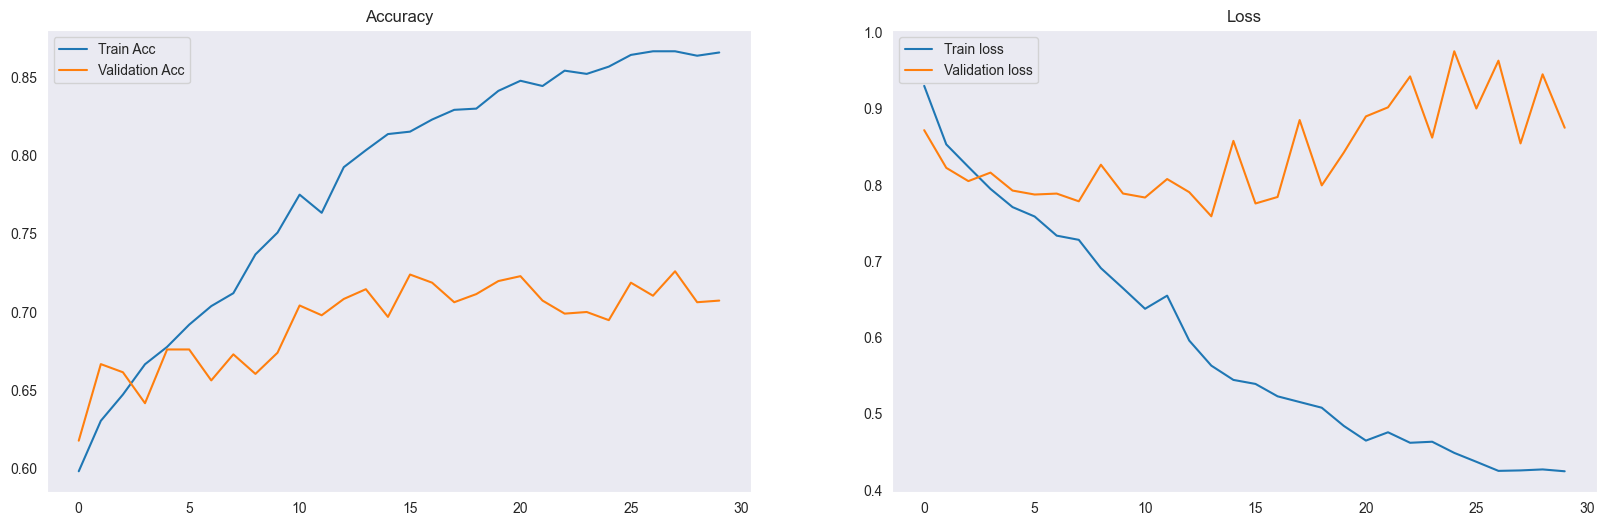

In [244]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(results["train_acc"], label='Train Acc')
plt.plot(results["test_acc"], label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(results["train_loss"], label='Train loss')
plt.plot(results["test_loss"], label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

In [257]:
import random
random_sample = random.choice(test_data)
random_sample

(tensor([  5, 449, 383, 213,  64,  77,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 tensor(2))

In [ ]:
model_0.eval()
with torch.inference_mode():
    pred = model_0(random_sample["X"].to(device))
pred